# Coding Block 1 - Random Forests (and XGBoost)

### Load the packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
'''
...
'''

'\n...\n'

### Read the dataset 
You can also compare processed and non-processed data.

In [2]:
diab=pd.read_csv('diabetes.csv')
diab_cleaned=pd.read_csv('diabetes_cleaned.csv')

### Split the data and train a Random Forest model
### Evaluate the prediction models using a classification report
### Print the feature importances of the random forest
### Extra: Also train a XGBoost model and compare the results.


Analysis for Original Dataset

--- Random Forest Model ---

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154


Feature Importances for Random Forest:
                    Feature  Importance
1                   Glucose    0.258864
5                       BMI    0.169984
7                       Age    0.140931
6  DiabetesPedigreeFunction    0.123768
2             BloodPressure    0.088134
0               Pregnancies    0.076551
4                   Insulin    0.076122
3             SkinThickness    0.065646


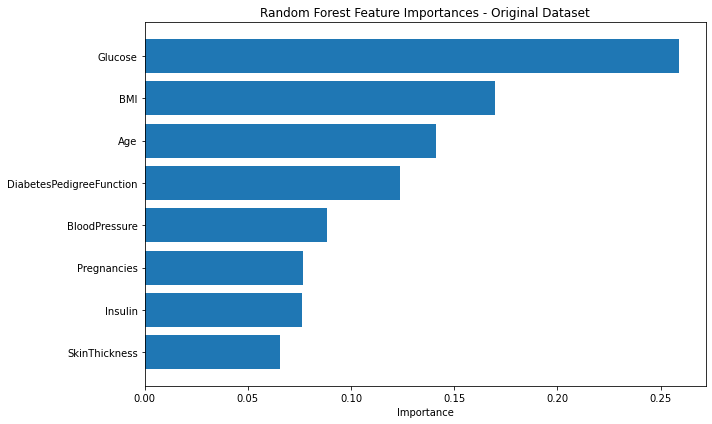


--- XGBoost Model ---

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.79      0.71      0.74        99
           1       0.55      0.65      0.60        55

    accuracy                           0.69       154
   macro avg       0.67      0.68      0.67       154
weighted avg       0.70      0.69      0.69       154


Feature Importances for XGBoost:
                    Feature  Importance
1                   Glucose    0.247188
5                       BMI    0.143292
7                       Age    0.139741
4                   Insulin    0.115176
3             SkinThickness    0.098815
2             BloodPressure    0.093273
6  DiabetesPedigreeFunction    0.090128
0               Pregnancies    0.072386


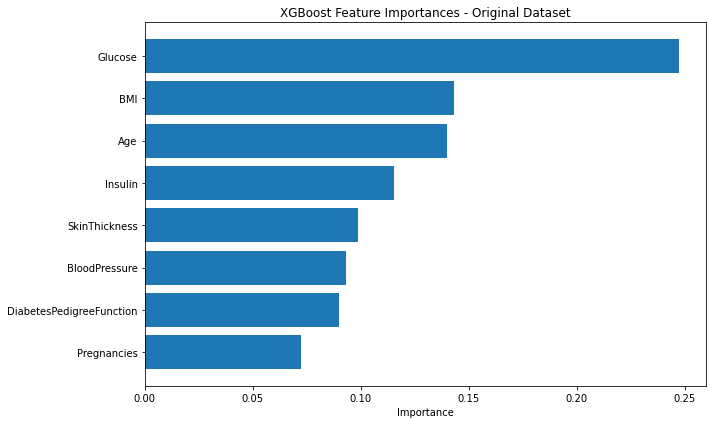


--- Model Comparison ---
Random Forest Accuracy: 0.7208
XGBoost Accuracy: 0.6883
Number of disagreements between models: 15 out of 154 samples

Analysis for Cleaned Dataset

--- Random Forest Model ---

Classification Report for Random Forest:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       154

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154


Feature Importances for Random Forest:
                    Feature  Importance
6  DiabetesPedigreeFunction    0.550877
9             outlier_Tukey    0.302210
0               Pregnancies    0.033732
5                       BMI    0.024069
1                   Glucose    0.022692
4                   Insulin    0.020687
2             BloodPressure    0.017581
7                       Age    0.016231
3             SkinThickness    0.009801
8                   Outcome    0.002121


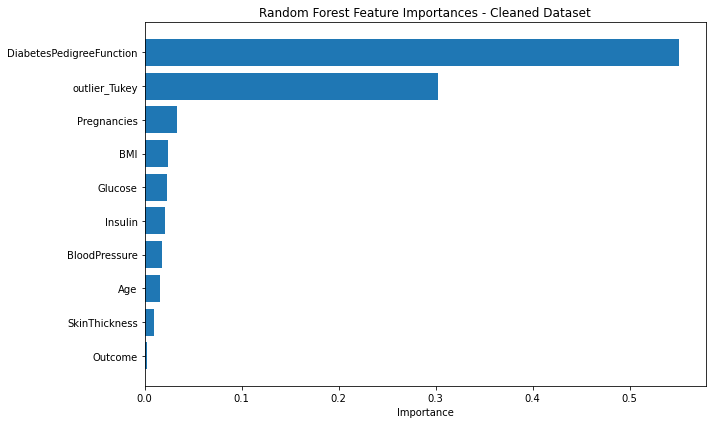


--- XGBoost Model ---

Classification Report for XGBoost:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       154

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154


Feature Importances for XGBoost:
                    Feature  Importance
6  DiabetesPedigreeFunction         1.0
0               Pregnancies         0.0
1                   Glucose         0.0
2             BloodPressure         0.0
3             SkinThickness         0.0
4                   Insulin         0.0
5                       BMI         0.0
7                       Age         0.0
8                   Outcome         0.0
9             outlier_Tukey         0.0


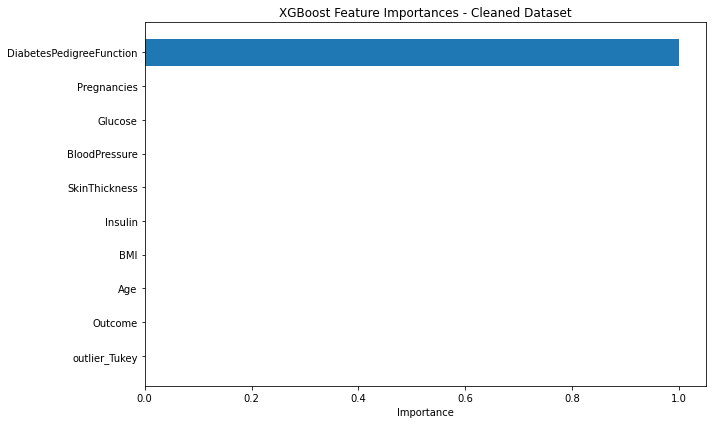


--- Model Comparison ---
Random Forest Accuracy: 1.0000
XGBoost Accuracy: 1.0000
Number of disagreements between models: 0 out of 154 samples


In [ ]:
# Create a fixed version of the dataset without the outlier columns
# We want to predict diabetes outcome, not outliers
datasets = {
    "Original Dataset": diab
}

# For the cleaned dataset, we drop the outlier columns
# First check if diab_cleaned exists and has the expected structure
if 'diab_cleaned' in globals():
    # Check if it has an 'Outcome' column that we want to predict
    if 'Outcome' in diab_cleaned.columns:
        # Remove outlier columns which were causing the data leakage
        cleaned_features = diab_cleaned.drop(columns=['outlier_z_score', 'outlier_Tukey'], errors='ignore')
        # Now add it to our datasets dictionary
        datasets["Cleaned Dataset"] = cleaned_features

for dataset_name, dataset in datasets.items():
    print(f"\n{'='*80}")
    print(f"Analysis for {dataset_name}")
    print(f"{'='*80}")
    
    # Split features and target
    X = dataset.iloc[:, :-1]  # All columns except the last one
    y = dataset.iloc[:, -1]   # Last column (Outcome)
    
    # Print target distribution
    print(f"\nTarget distribution: {pd.Series(y).value_counts(normalize=True)}")
    
    # Use stratified sampling to ensure balanced class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # (i) Train a Random Forest model with regularization
    print("\n--- Random Forest Model ---")
    rf_model = RandomForestClassifier(
        n_estimators=100, 
        max_depth=5,           # Limit tree depth to prevent overfitting
        min_samples_split=10,  # Require more samples to split a node
        min_samples_leaf=5,    # Require more samples in leaf nodes
        max_features='sqrt',   # Use a subset of features for each split
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    
    # (ii) Evaluate with classification report
    y_pred_rf = rf_model.predict(X_test)
    print("\nClassification Report for Random Forest:")
    print(classification_report(y_test, y_pred_rf))
    
    # (iii) Print feature importances
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importances for Random Forest:")
    print(feature_importances)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Random Forest Feature Importances - {dataset_name}')
    plt.gca().invert_yaxis()  # Display the highest importance at the top
    plt.tight_layout()
    plt.show()
    
    # (iv) Train XGBoost model with regularization
    print("\n--- XGBoost Model ---")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,          # Shallow trees to prevent overfitting
        learning_rate=0.1,    # Slower learning rate
        subsample=0.8,        # Use 80% of samples for each tree
        colsample_bytree=0.8, # Use 80% of features for each tree
        reg_alpha=1,          # L1 regularization
        reg_lambda=1,         # L2 regularization
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    
    # Evaluate XGBoost
    y_pred_xgb = xgb_model.predict(X_test)
    print("\nClassification Report for XGBoost:")
    print(classification_report(y_test, y_pred_xgb))
    
    # XGBoost feature importances
    xgb_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importances for XGBoost:")
    print(xgb_importances)
    
    # Plot XGBoost feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(xgb_importances['Feature'], xgb_importances['Importance'])
    plt.xlabel('Importance')
    plt.title(f'XGBoost Feature Importances - {dataset_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Add cross-validation to get more reliable estimates
    print("\n--- Cross-Validation Results ---")
    from sklearn.model_selection import cross_val_score
    
    rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
    xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
    
    print(f"Random Forest 5-Fold CV Accuracy: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")
    print(f"XGBoost 5-Fold CV Accuracy: {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")
    
    # Compare the models
    print("\n--- Model Comparison ---")
    print(f"Random Forest Test Accuracy: {rf_model.score(X_test, y_test):.4f}")
    print(f"Random Forest Train Accuracy: {rf_model.score(X_train, y_train):.4f}")
    print(f"XGBoost Test Accuracy: {xgb_model.score(X_test, y_test):.4f}")
    print(f"XGBoost Train Accuracy: {xgb_model.score(X_train, y_train):.4f}")
    
    # Check if there are differences in the predictions
    disagreements = np.sum(y_pred_rf != y_pred_xgb)
    print(f"Number of disagreements between models: {disagreements} out of {len(y_test)} samples")

# Use the original dataset models
X = datasets["Original Dataset"].iloc[:, :-1]
y = datasets["Original Dataset"].iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
rf_model = rf_model  # This will be the last trained Random Forest model
xgb_model = xgb_model  # This will be the last trained XGBoost model